In [15]:
import wfdb
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.signal import spectrogram

# Relevant record information
### fs: Frequency at which the signals were digitized (in this case 360Hz)
* time duration = sample count / sampling frequency
* 360Hz signal, which means 360 samples per second with a total length per record as 650000, or ~30 minutes
### sig_len: Signal length (or data points) in the record, where we have 650000 per record
### n_sig: How many channels were recorded.
* channel/Lead: refers to a single electrical signal recording from the heart, representing the voltage difference between two specific electrodes placed on the body (in this case two channels/Leads)
### units: Units for each channel (millivolts)
### sig_name: The signal name for each channel
### comments: Any comments written in the header by cardiologists

In [18]:
# Path to your data directory
data_dir = '../data/mit-bih-arrhythmia-database-1.0.0'

# List the files in the directory to find one of the ECG files
ecg_file = '100.dat'

# wfdb reads through the .hea and .dat files for record information
# .hea: header file with relevant information about the record (human-readable)
# .dat: binary data file with raw digitized ECG waveforms (machine-readable) 
# sampto: The sample number at which to stop reading for all channels. Reads the entire duration by default.

# Load the ECG data using WFDB
record = wfdb.rdrecord(os.path.join(data_dir, ecg_file.replace('.dat', '')))  # Load the full record

# Inspect basic information about the data
print(f"Record Name: {record.record_name}")
print(f"Number of Signals: {record.p_signal.shape[1]}")  # Use shape to get number of signals
print(f"Sampling Frequency: {record.fs} Hz")
print(f"Signal Shape: {record.p_signal.shape}")

Record Name: 100
Number of Signals: 2
Sampling Frequency: 360 Hz
Signal Shape: (650000, 2)


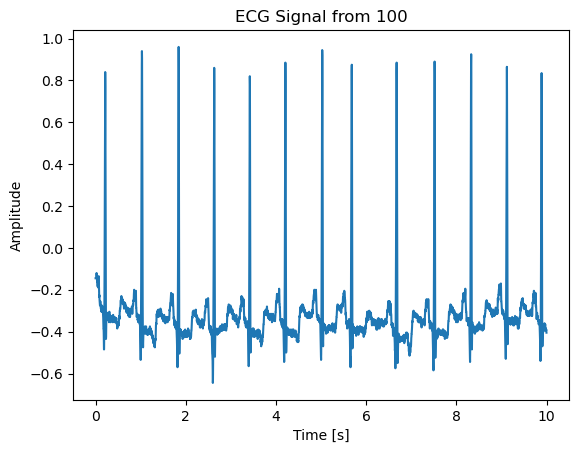

In [20]:
# Plot the first 10 seconds of the first ECG signal to get a sense of the data
time = np.arange(0, 10, 1/record.fs)  # Time vector for 10 seconds
plt.plot(time, record.p_signal[:len(time), 0])  # Plot the first signal (ECG)
plt.title(f'ECG Signal from {record.record_name}')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

Nothing crazy showing here, this seems to be baseline?

In [23]:
# Path to your data directory
data_dir = '../data/mit-bih-arrhythmia-database-1.0.0'

# Define the ECG file base (e.g., 'a01')
ecg_file_base = '100'

# Load the annotation file (e.g., 'a01.apn')
# wfdb reads through .atr for annotation info and creates an Annotation object
annotation_file = os.path.join(data_dir, f"{ecg_file_base}")
annotations = wfdb.rdann(annotation_file, 'atr')  # Read the apnea annotations

label_count = 0
# Accessing the annotations and printing the relevant details
for i in range(len(annotations.sample)):
    time = annotations.sample[i] / annotations.fs  # Convert sample to time (seconds)
    label = annotations.symbol[i]  # Get the label of the annotation
    print(f"Time: {time:.2f} seconds - Label: {label}")



Time: 0.05 seconds - Label: +
Time: 0.21 seconds - Label: N
Time: 1.03 seconds - Label: N
Time: 1.84 seconds - Label: N
Time: 2.63 seconds - Label: N
Time: 3.42 seconds - Label: N
Time: 4.21 seconds - Label: N
Time: 5.03 seconds - Label: N
Time: 5.68 seconds - Label: A
Time: 6.67 seconds - Label: N
Time: 7.52 seconds - Label: N
Time: 8.33 seconds - Label: N
Time: 9.12 seconds - Label: N
Time: 9.89 seconds - Label: N
Time: 10.73 seconds - Label: N
Time: 11.58 seconds - Label: N
Time: 12.41 seconds - Label: N
Time: 13.23 seconds - Label: N
Time: 14.06 seconds - Label: N
Time: 14.85 seconds - Label: N
Time: 15.65 seconds - Label: N
Time: 16.44 seconds - Label: N
Time: 17.26 seconds - Label: N
Time: 18.13 seconds - Label: N
Time: 18.95 seconds - Label: N
Time: 19.74 seconds - Label: N
Time: 20.53 seconds - Label: N
Time: 21.31 seconds - Label: N
Time: 22.09 seconds - Label: N
Time: 22.90 seconds - Label: N
Time: 23.72 seconds - Label: N
Time: 24.55 seconds - Label: N
Time: 25.39 seconds - 

In [25]:
# Count the occurrences of each label
label_counts = Counter(annotations.symbol)

print("Label Distribution:")
for label, count in label_counts.items():
    print(f"{label}: {count}")

Label Distribution:
+: 1
N: 2239
A: 33
V: 1


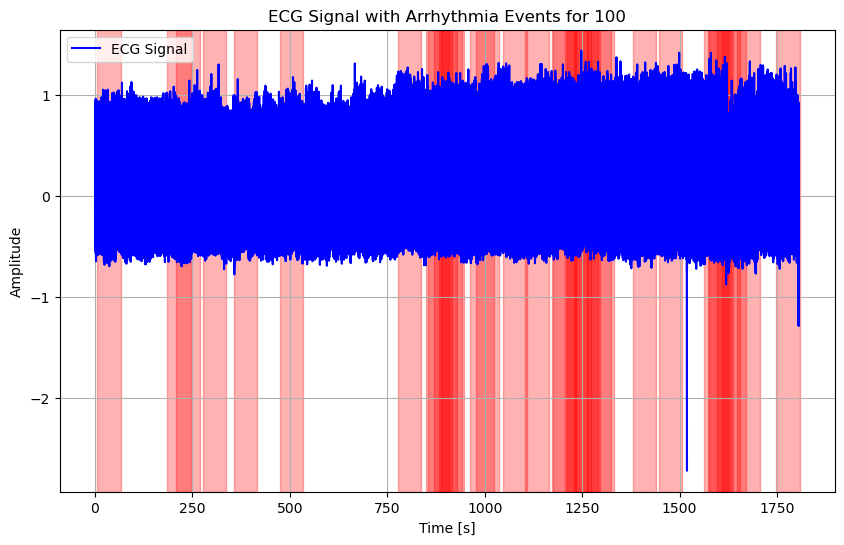

In [27]:
# Get the time and the signal
time = np.arange(0, len(record.p_signal) / record.fs, 1 / record.fs)  # Time vector for the ECG

# Plot the ECG signal (for the first channel)
plt.figure(figsize=(10, 6))
plt.plot(time, record.p_signal[:, 0], label="ECG Signal", color='blue')

# Highlight the apnea regions (where label 'A' occurs)
for i in range(len(annotations.sample)):
    if annotations.symbol[i] == 'A':  # Look for arrhythmia annotations
        # Convert sample to time
        start_time = annotations.sample[i] / annotations.fs
        end_time = start_time + 60  # Assumption: 1 minute duration for each apnea annotation
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)  # Highlight apnea period

# Add labels and title
plt.title(f"ECG Signal with Arrhythmia Events for {ecg_file_base}")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


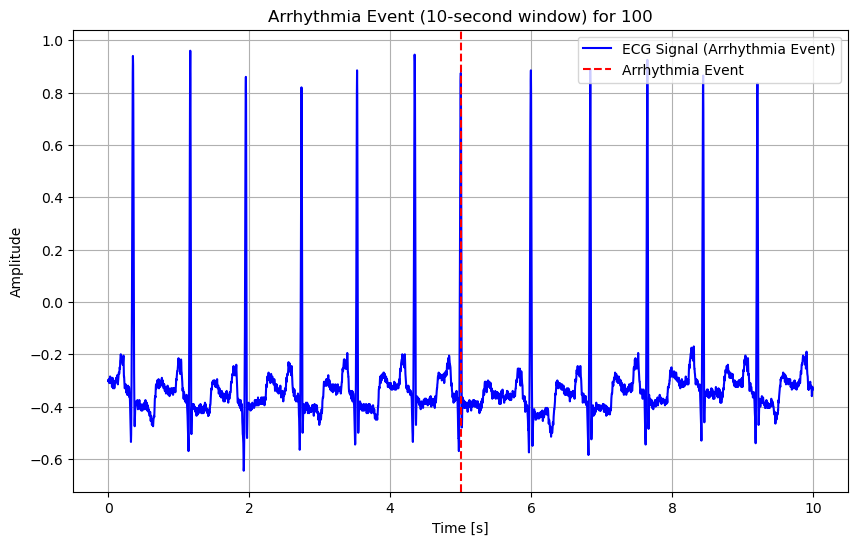

In [28]:
# Choose the first apnea event ('A')
for i in range(len(annotations.sample)):
    if annotations.symbol[i] == 'A':  # Look for the first apnea annotation
        apnea_sample = annotations.sample[i]
        break

# Define the time window around the apnea event (±5 seconds around the event)
window_start = apnea_sample - 5 * record.fs  # Start 5 seconds before the apnea
window_end = apnea_sample + 5 * record.fs    # End 5 seconds after the apnea

# Extract the ECG signal within the 10-second window
ecg_window = record.p_signal[window_start:window_end, 0]  # First channel
time_window = np.arange(0, len(ecg_window)) / record.fs  # Time vector for the window

# Plot the ECG signal for this 10-second window
plt.figure(figsize=(10, 6))
plt.plot(time_window, ecg_window, label="ECG Signal (Arrhythmia Event)", color='blue')

# Highlight the apnea event in the middle of the window
plt.axvline(x=5, color='red', linestyle='--', label='Arrhythmia Event')

# Add labels and title
plt.title(f"Arrhythmia Event (10-second window) for {ecg_file_base}")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

While the dotted red line specifies the point in time the sleep apnea becomes labeled as 'A', sleep apnea as a whole is categorized
as sustained period of abnormal breathing, so this entire window would be used to feed the CNN. 

[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]


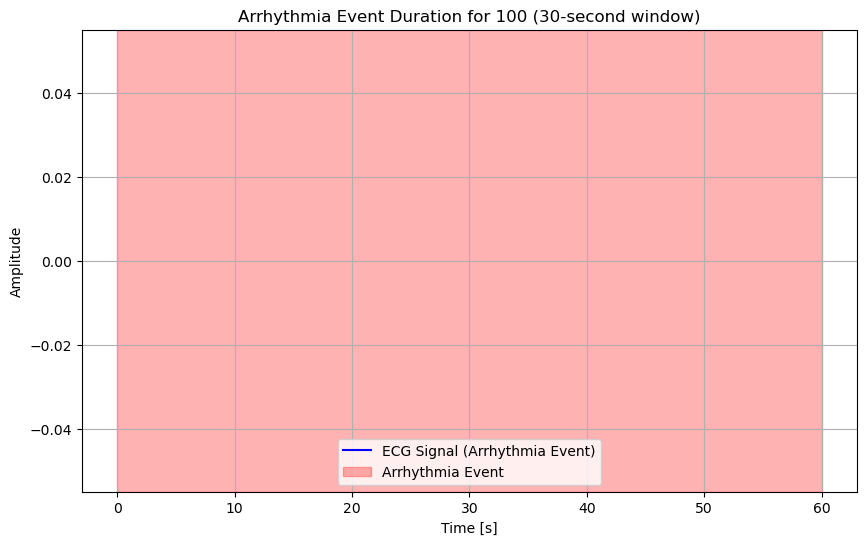

In [30]:
# Define the start and end times of the apnea event (in seconds)
# We'll use a larger window to view the entire event duration
event_duration = 60  # for example, look at 30 seconds of data around the apnea event
window_start = apnea_sample - event_duration * record.fs // 2  # Start 15 seconds before
window_end = apnea_sample + event_duration * record.fs // 2    # End 15 seconds after
print(record.p_signal)


# Extract the ECG signal within the window around the apnea event
ecg_window = record.p_signal[window_start:window_end, 0]  # First ECG signal
time_window = np.arange(0, len(ecg_window)) / record.fs  # Time vector for the window


# Plot the ECG signal for this window
plt.figure(figsize=(10, 6))
plt.plot(time_window, ecg_window, label="ECG Signal (Arrhythmia Event)", color='blue')

# Highlight the entire apnea event duration with a shaded region
plt.axvspan(0, event_duration, color='red', alpha=0.3, label='Arrhythmia Event')

# Add labels and title
plt.title(f"Arrhythmia Event Duration for {ecg_file_base} (30-second window)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


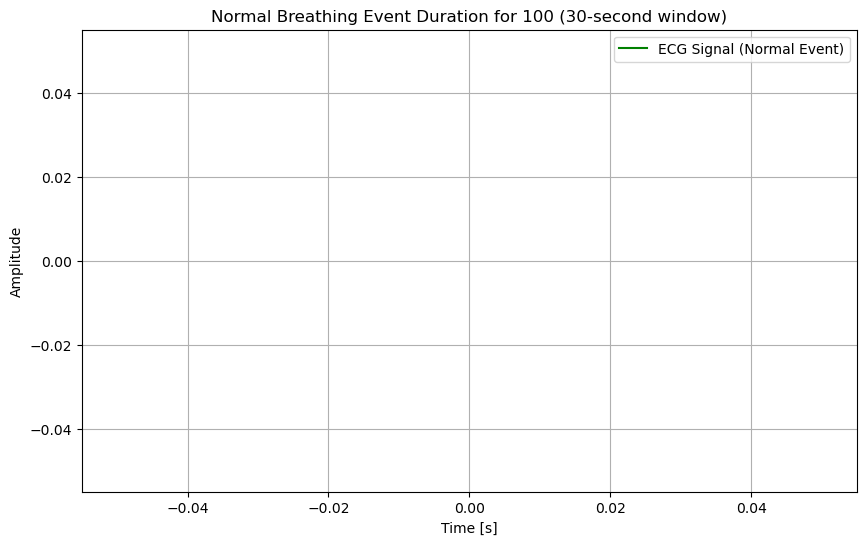

In [31]:
# Choose the first apnea event ('A')
for i in range(len(annotations.sample)):
    if annotations.symbol[i] == 'N':  # Look for the first apnea annotation
        normal_sample = annotations.sample[i]
        break

# Extract the ECG signal within the window around the normal event
ecg_window_normal = record.p_signal[window_start:window_end, 0]  # First ECG signal
time_window_normal = np.arange(0, len(ecg_window_normal)) / record.fs  # Time vector for the window

# Plot the ECG signal for this window
plt.figure(figsize=(10, 6))
plt.plot(time_window_normal, ecg_window_normal, label="ECG Signal (Normal Event)", color='green')

# Add labels and title
plt.title(f"Normal Breathing Event Duration for {ecg_file_base} (30-second window)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

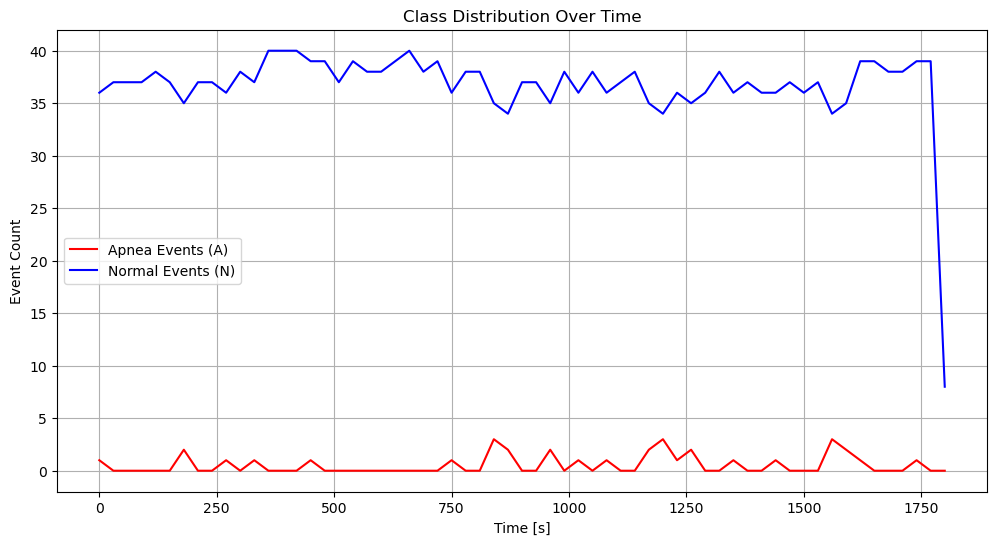

In [32]:
# Define the window size (in samples, e.g., 30 seconds worth of samples)
window_size = int(30 * record.fs)  # 30 seconds of data

# Extract annotation information as numpy arrays
annotation_samples = np.array(annotations.sample)
annotation_labels = np.array(annotations.symbol)

# Initialize lists to hold counts of "A" and "N" events in each window
apnea_counts = []
normal_counts = []

# Loop over the data in windows and count apnea events
start_time = 0
while start_time < len(record.p_signal):
    end_time = start_time + window_size
    # Get the annotations that fall within this window using boolean indexing
    window_annotations = annotation_samples[(annotation_samples >= start_time) & (annotation_samples < end_time)]
    window_labels = annotation_labels[(annotation_samples >= start_time) & (annotation_samples < end_time)]
    
    # Count the number of apneas ("A") and normal events ("N") in this window
    apnea_count = np.sum(window_labels == 'A')
    normal_count = np.sum(window_labels == 'N')
    
    # Append counts to the respective lists
    apnea_counts.append(apnea_count)
    normal_counts.append(normal_count)
    
    start_time = end_time  # Move to the next window

# Time axis for the windows
time_windows = np.arange(0, len(record.p_signal), window_size) / record.fs  # Convert to seconds

# Plot the class distribution over time
plt.figure(figsize=(12, 6))
plt.plot(time_windows, apnea_counts, label='Apnea Events (A)', color='red')
plt.plot(time_windows, normal_counts, label='Normal Events (N)', color='blue')
plt.xlabel('Time [s]')
plt.ylabel('Event Count')
plt.title('Class Distribution Over Time')
plt.legend()
plt.grid(True)
plt.show()


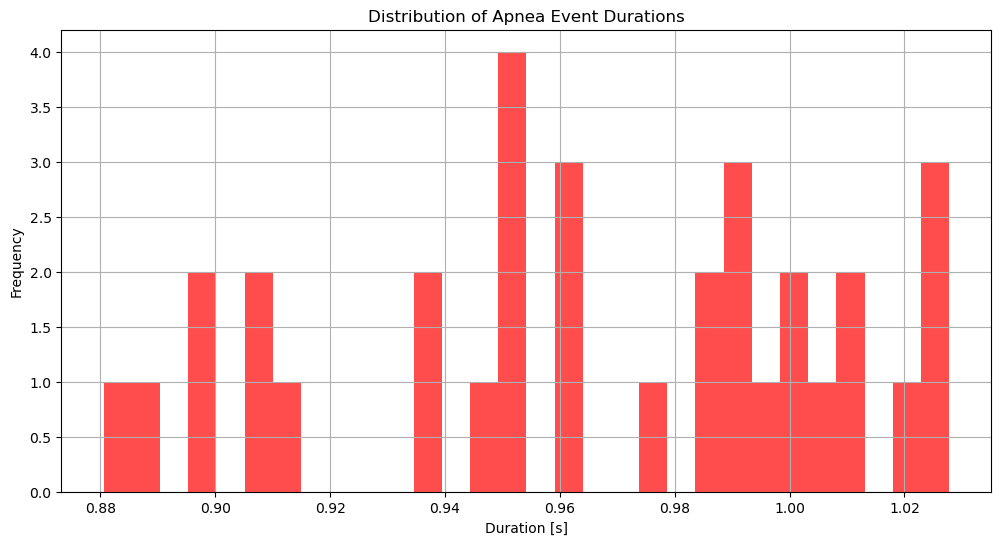

Average Apnea Duration: 0.96 seconds (0.02 minutes)


In [33]:
# Calculate the duration of each apnea event
apnea_durations = []

# Iterate over all annotations to find apnea events and calculate their duration
for i in range(1, len(annotations.sample)):
    if annotations.symbol[i] == 'A':  # If this annotation is an apnea event
        start_sample = annotations.sample[i]
        # Find the next annotation that is not an apnea
        for j in range(i+1, len(annotations.sample)):
            if annotations.symbol[j] != 'A':  # Found end of the apnea event
                end_sample = annotations.sample[j]
                break
        else:
            end_sample = len(record.p_signal)  # If no end is found, take the end of the signal
        
        apnea_duration = (end_sample - start_sample) / record.fs  # Convert samples to seconds
        apnea_durations.append(apnea_duration)

# Calculate the average duration of apnea events
average_apnea_duration = np.mean(apnea_durations)

# Plot the duration of each apnea event
plt.figure(figsize=(12, 6))
plt.hist(apnea_durations, bins=30, color='red', alpha=0.7)
plt.title('Distribution of Apnea Event Durations')
plt.xlabel('Duration [s]')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print the average duration with minutes in parentheses
average_apnea_duration_minutes = average_apnea_duration / 60  # Convert to minutes
print(f"Average Apnea Duration: {average_apnea_duration:.2f} seconds ({average_apnea_duration_minutes:.2f} minutes)")


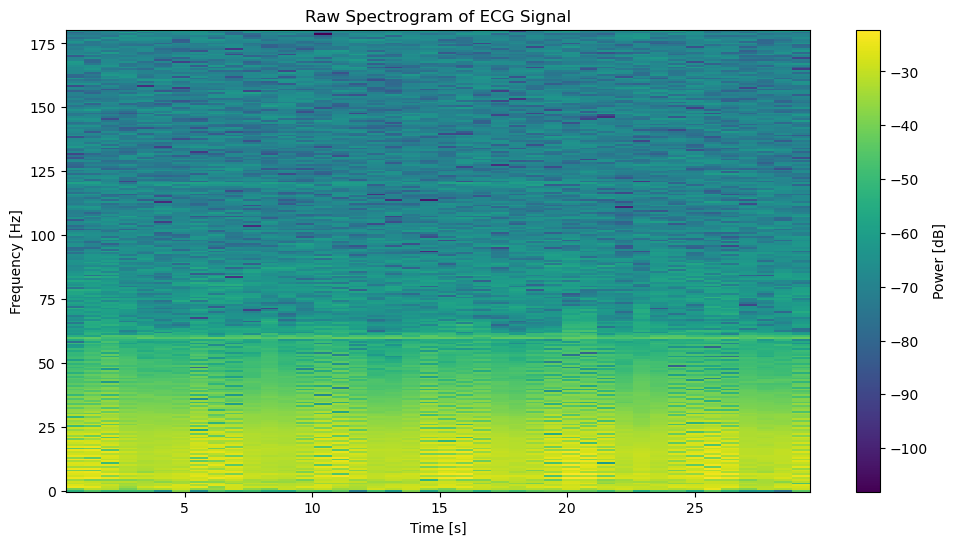

In [34]:
# Define the window size and overlap size
window_size = 500  # Length of the window (samples)
overlap_size = 250  # Overlap between windows (samples)

# Select a segment of the ECG signal to work with (for example, the first 30 seconds)
ecg_window = record.p_signal[:30 * record.fs, 0]  # First ECG signal for 30 seconds
time_window = np.arange(0, len(ecg_window)) / record.fs  # Time vector for the window

# Compute the raw spectrogram
f, t, Sxx = spectrogram(ecg_window, fs=record.fs, nperseg=window_size, noverlap=overlap_size)

# Plot the raw spectrogram
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='auto')  # Convert to dB for better visualization
plt.title('Raw Spectrogram of ECG Signal')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power [dB]')
plt.show()


This is a raw spectrogram which compared to a regular one, can be harder for the model to interpret because they might be too variable or noisy, which is why we might need to continously try to process them (like applying a logarithmic transformation) to make the values more consistent and easier to work with. Processing them into non-raw spectrograms has been quite difficult and always producing empty graphs.